<a href="https://colab.research.google.com/github/lorenzophys/deep-learning-playground/blob/main/MNIST_fashion/MNIST_fashion_CNN_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST fashion CNN experiments

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from scipy.stats import norm

Loading the data from Keras.

In [6]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

Check the shapes of the images.

In [7]:
print('Train', train_images.shape, train_labels.shape)
print('Test', test_images.shape, test_labels.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


The name of the classes can be found here: https://github.com/zalandoresearch/fashion-mnist

In [8]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress','Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

A preview of the images:

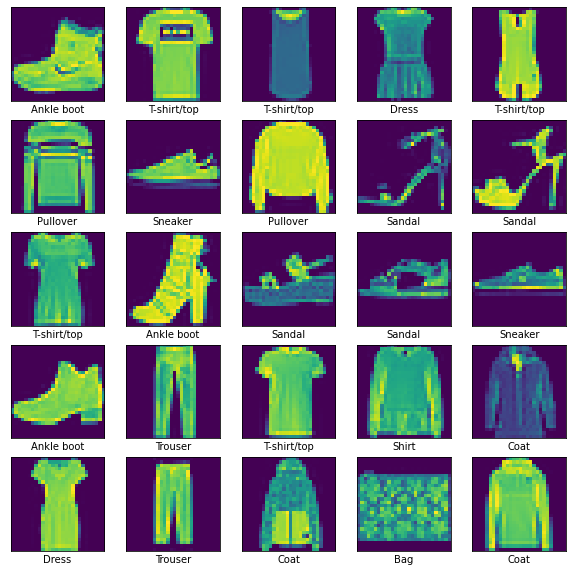

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i])
    plt.xlabel(classes[train_labels[i]])
plt.show()



The images must be reshaped before being fed into the convolutional layer.


In [9]:
train_images = train_images.reshape(-1,28,28,1)
test_images = test_images.reshape(-1,28,28,1)

print('Train', train_images.shape, train_labels.shape)
print('Test', test_images.shape, test_labels.shape)

Train (60000, 28, 28, 1) (60000,)
Test (10000, 28, 28, 1) (10000,)


Normalization. Normally you should check, but I already know that the pixels range from 0 to 255.

In [10]:
train_images, test_images = train_images/255., test_images/255.

I want to try different architectures to see which one gets the best accuracy. I will start by choosing the number of Convolution+Pooling layers. I stop with three because the fourth would reduce the size of the input too much.

In [ ]:
names = ["CPx1","CPx2", "CPx3"]
nets = len(names)
model_1 = [0] * nets
history_1 = [0] * nets
epochs_1 = 30

In [ ]:
for i in range(nets):
  model_1[i] = keras.models.Sequential()
  model_1[i].add(keras.layers.Conv2D(filters=16, kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
  model_1[i].add(keras.layers.MaxPool2D())
  if i>0:
    model_1[i].add(keras.layers.Conv2D(filters=32, kernel_size=5, padding="same", activation="relu"))
    model_1[i].add(keras.layers.MaxPool2D())
  if i>1:
    model_1[i].add(keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"))
    model_1[i].add(keras.layers.MaxPool2D())
  model_1[i].add(keras.layers.Flatten())
  model_1[i].add(keras.layers.Dense(512, activation='relu'))
  model_1[i].add(keras.layers.Dense(64, activation='relu'))
  model_1[i].add(keras.layers.Dense(10, activation='softmax'))

  model_1[i].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

For all the models I used the standard approach: adam optimizer, the sparse categorical crossentropy loss function, the relu activation for the first layers and the softmax for the output layer to encode probablility. The number of filters will be adjusted later. After the convolutions we have two dense layers with 512-64 neurons: this is the number that gave the best results for the same dataset, see the other notebook. This will also be adjusted later. For every model I want to check what's the maximum value of the accuracy on the training and validation set.

In [ ]:
for i in range(nets):
  history_1[i] = model_1[i].fit(train_images, train_labels,
                                epochs=epochs_1,
                                validation_data=(test_images, test_labels),
                                verbose=0)
  
  max_train_acc_1 = np.max(history_1[i].history['accuracy'])
  max_val_acc_1 = np.max(history_1[i].history['val_accuracy'])

  print(f"Type = {names[i]}, Max train accuracy = {max_train_acc_1:.5f}, Max val accuracy = {max_val_acc_1:.5f}")

Type = CPx1, Max train accuracy = 0.99560, Max val accuracy = 0.91550
Type = CPx2, Max train accuracy = 0.99417, Max val accuracy = 0.91790
Type = CPx3, Max train accuracy = 0.98725, Max val accuracy = 0.91690


There is little to no difference between two or three CP layers. I choose to go with CPx2.

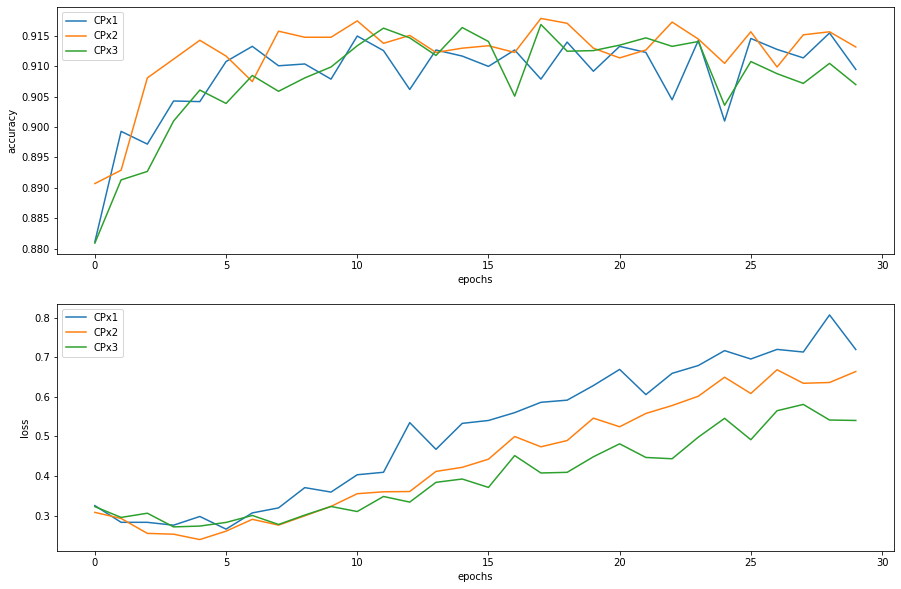

In [ ]:
ax1, ax2 = plt.figure(figsize=(15,10)).subplots(2)

for i in range(len(names)):
  ax1.plot(history_1[i].history["val_accuracy"])
  ax2.plot(history_1[i].history["val_loss"])

ax1.set(xlabel='epochs', ylabel='accuracy')
ax1.legend(names)
ax2.set(xlabel='epochs', ylabel='loss')
ax2.legend(names)
plt.show()

For the second experiment I want to determine the best combination of filters. I try different powers of two.

In [ ]:
names_2 = ["8-16", "16-32", "32-64", "64-128", "128-256"]
nets_2 = len(names_2)
model_2 = [0] * nets_2
history_2 = [0] * nets_2
epochs_2 = 30

In [ ]:
for i in range(nets_2):
  model_2[i] = keras.models.Sequential()
  model_2[i].add(keras.layers.Conv2D(filters=2**(i+3), kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
  model_2[i].add(keras.layers.MaxPool2D())
  model_2[i].add(keras.layers.Conv2D(filters=2**(i+4), kernel_size=5, padding="same", activation="relu"))
  model_2[i].add(keras.layers.MaxPool2D())
  model_2[i].add(keras.layers.Flatten())
  model_2[i].add(keras.layers.Dense(512, activation='relu'))
  model_2[i].add(keras.layers.Dense(64, activation='relu'))
  model_2[i].add(keras.layers.Dense(10, activation='softmax'))
  model_2[i].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
for i in range(nets_2):
  history_2[i] = model_2[i].fit(train_images, train_labels,
                                epochs=epochs_2,
                                validation_data=(test_images, test_labels),
                                verbose=0)
  
  max_train_acc_2 = np.max(history_2[i].history['accuracy'])
  max_val_acc_2 = np.max(history_2[i].history['val_accuracy'])

  print(f"Type = {names_2[i]}, Max train accuracy = {max_train_acc_2:.5f}, Max val accuracy = {max_val_acc_2:.5f}")

Type = 8-16, Max train accuracy = 0.99205, Max val accuracy = 0.91470
Type = 16-32, Max train accuracy = 0.99355, Max val accuracy = 0.91760
Type = 32-64, Max train accuracy = 0.99417, Max val accuracy = 0.92130
Type = 64-128, Max train accuracy = 0.99530, Max val accuracy = 0.92230
Type = 128-256, Max train accuracy = 0.99507, Max val accuracy = 0.92260


The combination 64-128 is the best one

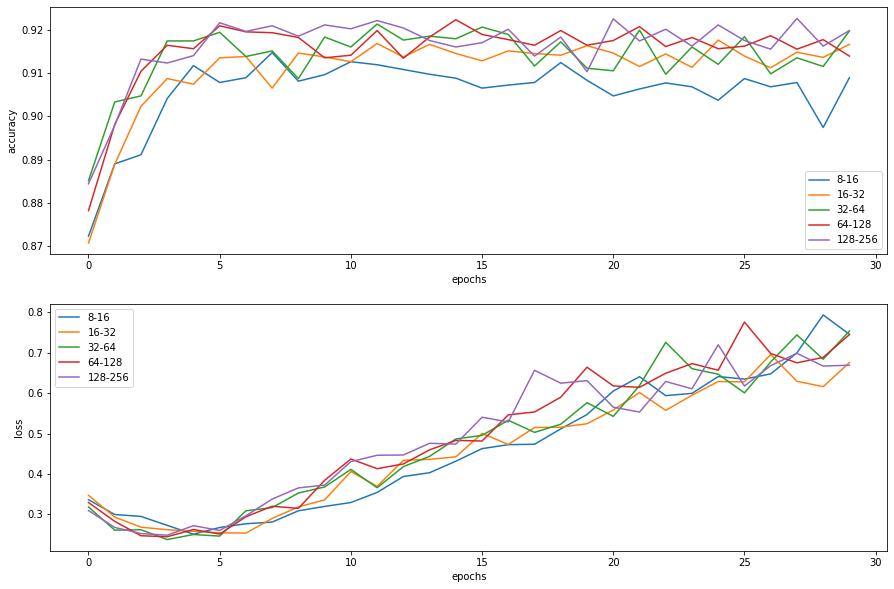

In [ ]:
ax1, ax2 = plt.figure(figsize=(15,10)).subplots(2)

for i in range(len(names_2)):
  ax1.plot(history_2[i].history["val_accuracy"])
  ax2.plot(history_2[i].history["val_loss"])

ax1.set(xlabel='epochs', ylabel='accuracy')
ax1.legend(names_2)
ax2.set(xlabel='epochs', ylabel='loss')
ax2.legend(names_2)
plt.show()

In the third experiment I want to determine the best dropout rate.

In [ ]:
names_drop = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"]
nets_drop = len(names_drop)
model_drop = [0] * nets_drop
history_drop = [0] * nets_drop
epochs_drop = 30

In [ ]:
for i in range(nets_drop):
  model_drop[i] = keras.models.Sequential()
  model_drop[i].add(keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
  model_drop[i].add(keras.layers.MaxPool2D())
  model_drop[i].add(keras.layers.Dropout(0.1*(i+1)))
  model_drop[i].add(keras.layers.Conv2D(filters=128, kernel_size=5, padding="same", activation="relu"))
  model_drop[i].add(keras.layers.MaxPool2D())
  model_drop[i].add(keras.layers.Dropout(0.1*(i+1)))
  model_drop[i].add(keras.layers.Flatten())
  model_drop[i].add(keras.layers.Dense(512, activation='relu'))
  model_drop[i].add(keras.layers.Dropout(0.1*(i+1)))
  model_drop[i].add(keras.layers.Dense(64, activation='relu'))
  model_drop[i].add(keras.layers.Dropout(0.1*(i+1)))
  model_drop[i].add(keras.layers.Dense(10, activation='softmax'))
  model_drop[i].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
for i in range(nets_drop):
  history_drop[i] = model_drop[i].fit(train_images, train_labels,
                                      epochs=epochs_drop,
                                      validation_data=(test_images, test_labels),
                                      verbose=0)
  
  max_train_acc_drop = np.max(history_drop[i].history['accuracy'])
  max_val_acc_drop = np.max(history_drop[i].history['val_accuracy'])
  
  print(f"Dropout: {names_drop[i]}, Max train accuracy = {max_train_acc_drop:.5f}, Max val accuracy = {max_val_acc_drop:.5f}")

Dropout: 0.1, Max train accuracy = 0.98755, Max val accuracy = 0.92630
Dropout: 0.2, Max train accuracy = 0.97257, Max val accuracy = 0.92780
Dropout: 0.3, Max train accuracy = 0.95410, Max val accuracy = 0.92700
Dropout: 0.4, Max train accuracy = 0.93027, Max val accuracy = 0.92320
Dropout: 0.5, Max train accuracy = 0.90398, Max val accuracy = 0.91500
Dropout: 0.6, Max train accuracy = 0.87638, Max val accuracy = 0.90160
Dropout: 0.7, Max train accuracy = 0.83187, Max val accuracy = 0.87390
Dropout: 0.8, Max train accuracy = 0.72828, Max val accuracy = 0.79460
Dropout: 0.9, Max train accuracy = 0.35463, Max val accuracy = 0.23160


The best performing model has a dropout of 30%.

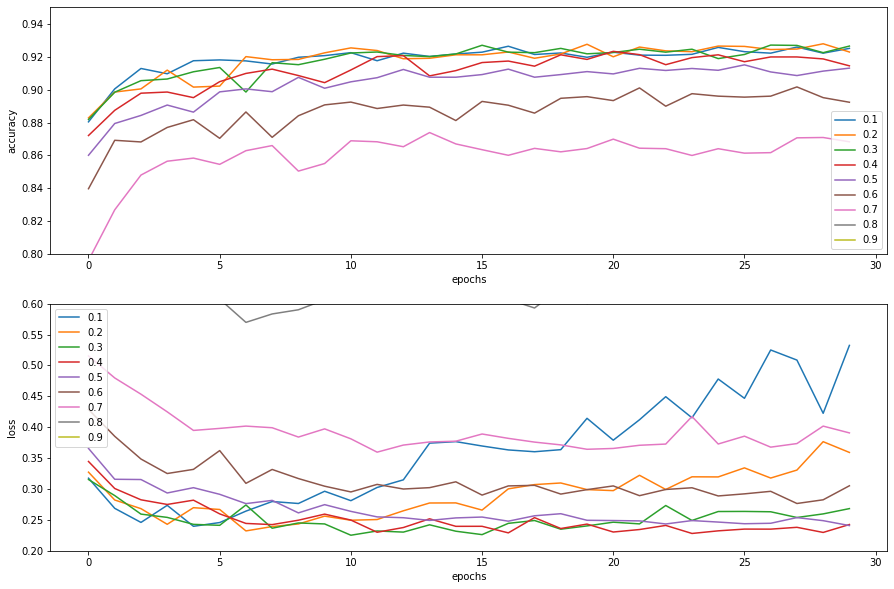

In [ ]:
ax1, ax2 = plt.figure(figsize=(15,10)).subplots(2)

for i in range(len(names_drop)):
  ax1.plot(history_drop[i].history["val_accuracy"])
  ax2.plot(history_drop[i].history["val_loss"])

ax1.set(xlabel='epochs', ylabel='accuracy')
ax1.set_ylim([0.80, 0.95])
ax1.legend(names_drop)
ax2.set(xlabel='epochs', ylabel='loss')
ax2.set_ylim([0.20, 0.60])
ax2.legend(names_drop)
plt.show()

Time to adjust the number of neurons in the dense layer.

In [ ]:
hidden_neurons = [0, 32, 64, 128, 256, 512, 1024]
model_hidden = [0] * len(hidden_neurons)

In [ ]:
for i in range(len(hidden_neurons)):
  model_hidden[i] = keras.models.Sequential()
  model_hidden[i].add(keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
  model_hidden[i].add(keras.layers.MaxPool2D())
  model_hidden[i].add(keras.layers.Dropout(0.3))
  model_hidden[i].add(keras.layers.Conv2D(filters=128, kernel_size=5, padding="same", activation="relu"))
  model_hidden[i].add(keras.layers.MaxPool2D())
  model_hidden[i].add(keras.layers.Dropout(0.3))
  model_hidden[i].add(keras.layers.Flatten())
  if i>0:
    model_hidden[i].add(keras.layers.Dense(hidden_neurons[i], activation="relu"))
    model_hidden[i].add(keras.layers.Dropout(0.3))
  model_hidden[i].add(keras.layers.Dense(10, activation="softmax"))

  model_hidden[i].compile(optimizer="adam",
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])

In [ ]:
history_hidden = [0] * len(hidden_neurons)
epochs_hidden = 30

In [ ]:
for i in range(len(hidden_neurons)):
  history_hidden[i] = model_hidden[i].fit(train_images, train_labels,
                                          epochs=epochs_hidden,
                                          validation_data=(test_images, test_labels),
                                          verbose=0)
  
  max_acc_hid = np.max(history_hidden[i].history['accuracy'])
  max_val_acc_hid = np.max(history_hidden[i].history['val_accuracy'])
  
  print(f"Hidden neurons = {hidden_neurons[i]}, Max train acc = {max_acc_hid:.5f}, Max val acc = {max_val_acc_hid:.5f}")

Hidden neurons = 0, Max train acc = 0.95493, Max val acc = 0.92160
Hidden neurons = 32, Max train acc = 0.93023, Max val acc = 0.92390
Hidden neurons = 64, Max train acc = 0.94280, Max val acc = 0.92540
Hidden neurons = 128, Max train acc = 0.95087, Max val acc = 0.92650
Hidden neurons = 256, Max train acc = 0.95748, Max val acc = 0.92600
Hidden neurons = 512, Max train acc = 0.96253, Max val acc = 0.92640
Hidden neurons = 1024, Max train acc = 0.96408, Max val acc = 0.92550


I decided to reduce the complexity and lower the number of neurons to 128 without a second hidden layer.

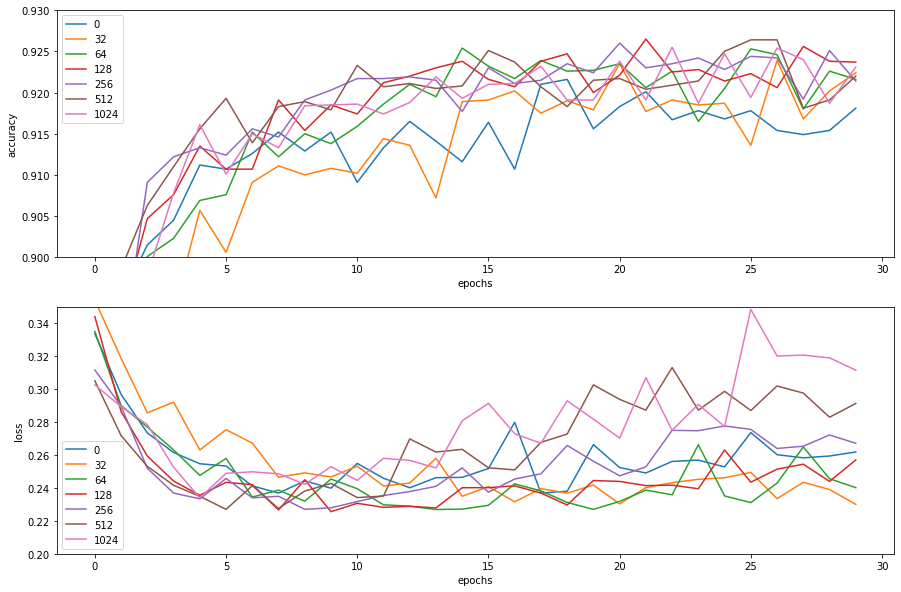

In [ ]:
ax1, ax2 = plt.figure(figsize=(15,10)).subplots(2)

for i in range(len(hidden_neurons)):
  ax1.plot(history_hidden[i].history["val_accuracy"])
  ax2.plot(history_hidden[i].history["val_loss"])

ax1.set(xlabel='epochs', ylabel='accuracy')
ax1.set_ylim([0.90, 0.93])
ax1.legend(hidden_neurons)
ax2.set(xlabel='epochs', ylabel='loss')
ax2.set_ylim([0.20, 0.35])
ax2.legend(hidden_neurons)
plt.show()

Bow I want to try different architectures:


1.   Replace MaxPooling with a CS2 layer (convolutional with strides=2) for downsampling
2.   Standard Convolutional-MaxPooling
3. Replace MaxPooling with CS2 layer and replace the convolutional layer with kernel_size=5 with two convolutional layers with kernel_size=3, plus BatchNormalization
4. Replace the convolutional layer with kernel_size=5 with two convolutional layers with kernel_size=3, plus BatchNormalization and MaxPooling



In [ ]:
model_CS2 = keras.models.Sequential()
model_CS2.add(keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
model_CS2.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, padding="same", activation="relu"))
model_CS2.add(keras.layers.Dropout(0.3))
model_CS2.add(keras.layers.Conv2D(filters=128, kernel_size=5, padding="same", activation="relu"))
model_CS2.add(keras.layers.Conv2D(filters=128, kernel_size=5, strides=2, padding="same", activation="relu"))
model_CS2.add(keras.layers.Dropout(0.3))
model_CS2.add(keras.layers.Flatten())
model_CS2.add(keras.layers.Dense(128, activation='relu'))
model_CS2.add(keras.layers.Dropout(0.3))
model_CS2.add(keras.layers.Dense(10, activation='softmax'))
model_CS2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]) 

In [ ]:
model_maxpool = keras.models.Sequential()
model_maxpool.add(keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
model_maxpool.add(keras.layers.MaxPool2D())
model_maxpool.add(keras.layers.Dropout(0.3))
model_maxpool.add(keras.layers.Conv2D(filters=128, kernel_size=5, padding="same", activation="relu"))
model_maxpool.add(keras.layers.MaxPool2D())
model_maxpool.add(keras.layers.Dropout(0.3))
model_maxpool.add(keras.layers.Flatten())
model_maxpool.add(keras.layers.Dense(128, activation='relu'))
model_maxpool.add(keras.layers.Dropout(0.3))
model_maxpool.add(keras.layers.Dense(10, activation='softmax'))
model_maxpool.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]) 

In [ ]:
model_batchnorm = keras.models.Sequential()
model_batchnorm.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", input_shape=(28, 28, 1)))
model_batchnorm.add(keras.layers.BatchNormalization())
model_batchnorm.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model_batchnorm.add(keras.layers.BatchNormalization())
model_batchnorm.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, padding="same", activation="relu"))
model_batchnorm.add(keras.layers.BatchNormalization())
model_batchnorm.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
model_batchnorm.add(keras.layers.BatchNormalization())
model_batchnorm.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
model_batchnorm.add(keras.layers.BatchNormalization())
model_batchnorm.add(keras.layers.Conv2D(filters=128, kernel_size=5, strides=2, padding="same", activation="relu"))
model_batchnorm.add(keras.layers.BatchNormalization())
model_batchnorm.add(keras.layers.Flatten())
model_batchnorm.add(keras.layers.Dense(128, activation='relu'))
model_batchnorm.add(keras.layers.BatchNormalization())
model_batchnorm.add(keras.layers.Dense(10, activation='softmax'))
model_batchnorm.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model_batchnorm_MP = keras.models.Sequential()
model_batchnorm_MP.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", input_shape=(28, 28, 1)))
model_batchnorm_MP.add(keras.layers.BatchNormalization())
model_batchnorm_MP.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model_batchnorm_MP.add(keras.layers.MaxPool2D())
model_batchnorm_MP.add(keras.layers.BatchNormalization())
model_batchnorm_MP.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
model_batchnorm_MP.add(keras.layers.BatchNormalization())
model_batchnorm_MP.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
model_batchnorm_MP.add(keras.layers.MaxPool2D())
model_batchnorm_MP.add(keras.layers.BatchNormalization())
model_batchnorm_MP.add(keras.layers.Flatten())
model_batchnorm_MP.add(keras.layers.Dense(128, activation='relu'))
model_batchnorm_MP.add(keras.layers.BatchNormalization())
model_batchnorm_MP.add(keras.layers.Dense(10, activation='softmax'))
model_batchnorm_MP.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history_CS2 = model_CS2.fit(train_images, train_labels,
                            epochs=30,
                            validation_data=(test_images, test_labels),
                            verbose=0)
max_acc_CS2 = np.max(history_CS2.history['accuracy'])
max_val_acc_CS2 = np.max(history_CS2.history['val_accuracy'])
print(f"Model: CS2, Max train accuracy = {max_acc_CS2:.5f}, Max val accuracy = {max_val_acc_CS2:.5f}")

history_maxpool = model_maxpool.fit(train_images, train_labels,
                                    epochs=30,
                                    validation_data=(test_images, test_labels),
                                    verbose=0)
max_acc_maxpool = np.max(history_maxpool.history['accuracy'])
max_val_acc_maxpool = np.max(history_maxpool.history['val_accuracy'])
print(f"Model: MaxPool, Max train accuracy = {max_acc_maxpool:.5f}, Max val accuracy = {max_val_acc_maxpool:.5f}")

history_batchnorm = model_batchnorm.fit(train_images, train_labels,
                                        epochs=30,
                                        validation_data=(test_images, test_labels),
                                        verbose=0)
  
max_acc_batchnorm = np.max(history_batchnorm.history['accuracy'])
max_val_acc_batchnorm = np.max(history_batchnorm.history['val_accuracy'])
print(f"Model: BatchNorm, Max train accuracy = {max_acc_batchnorm:.5f}, Max val accuracy = {max_val_acc_batchnorm:.5f}")

history_batchnorm_MP = model_batchnorm_MP.fit(train_images, train_labels,
                                              epochs=30,
                                              validation_data=(test_images, test_labels),
                                              verbose=0)
  
max_acc_batchnorm_MP = np.max(history_batchnorm_MP.history['accuracy'])
max_val_acc_batchnorm_MP = np.max(history_batchnorm_MP.history['val_accuracy'])
print(f"Model: BatchNorm and MP, Max train accuracy = {max_acc_batchnorm_MP:.5f}, Max val accuracy = {max_val_acc_batchnorm_MP:.5f}")

Model: CS2, Max train accuracy = 0.96032, Max val accuracy = 0.92510
Model: MaxPool, Max train accuracy = 0.95332, Max val accuracy = 0.92650
Model: BatchNorm, Max train accuracy = 0.99712, Max val accuracy = 0.93540
Model: BatchNorm and MP, Max train accuracy = 0.99698, Max val accuracy = 0.93800


Out of curiosity: Standard Convolutional-MaxPooling, plus BatchNormalization

In [ ]:
model_batchnorm_MP_less = keras.models.Sequential()
model_batchnorm_MP_less.add(keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
model_batchnorm_MP_less.add(keras.layers.BatchNormalization())
model_batchnorm_MP_less.add(keras.layers.MaxPool2D())
model_batchnorm_MP_less.add(keras.layers.BatchNormalization())
model_batchnorm_MP_less.add(keras.layers.Conv2D(filters=128, kernel_size=5, padding="same", activation="relu"))
model_batchnorm_MP_less.add(keras.layers.BatchNormalization())
model_batchnorm_MP_less.add(keras.layers.MaxPool2D())
model_batchnorm_MP_less.add(keras.layers.BatchNormalization())
model_batchnorm_MP_less.add(keras.layers.Flatten())
model_batchnorm_MP_less.add(keras.layers.Dense(128, activation='relu'))
model_batchnorm_MP_less.add(keras.layers.BatchNormalization())
model_batchnorm_MP_less.add(keras.layers.Dense(10, activation='softmax'))
model_batchnorm_MP_less.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history_batchnorm_MP_less = model_batchnorm_MP_less.fit(train_images, train_labels,
                                              epochs=30,
                                              validation_data=(test_images, test_labels),
                                              verbose=0)
  
max_acc_batchnorm_MP_less = np.max(history_batchnorm_MP_less.history['accuracy'])
max_val_acc_batchnorm_MP_less = np.max(history_batchnorm_MP_less.history['val_accuracy'])
print(f"Model: BatchNorm and MP less conv, Max train accuracy = {max_acc_batchnorm_MP_less:.5f}, Max val accuracy = {max_val_acc_batchnorm_MP_less:.5f}")

Model: BatchNorm and MP less conv, Max train accuracy = 0.99567, Max val accuracy = 0.92480


The best model is the one that uses BatchNormalization, MaxPooling and splits the convolutional layer with kernel_size=5 with two convolutional layers with kernel_size=3.

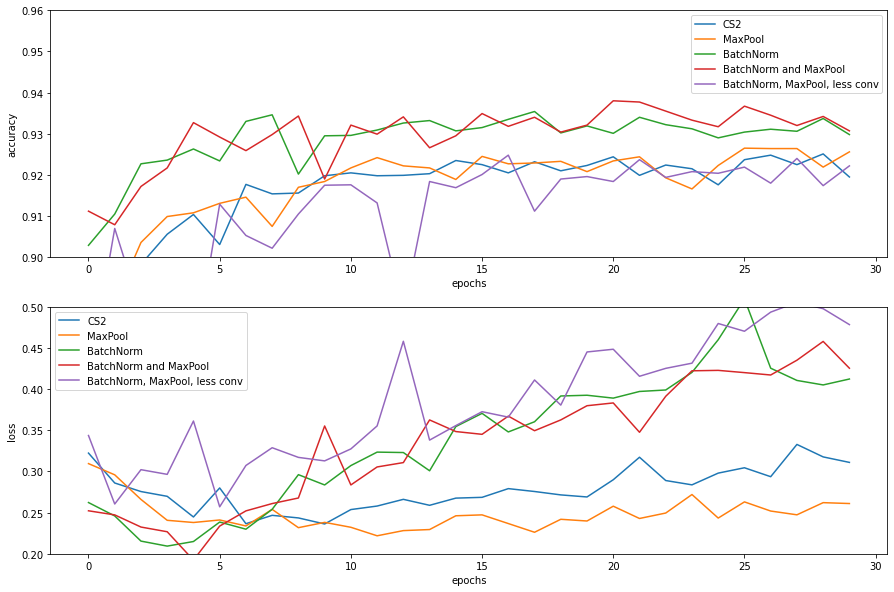

In [ ]:
ax1, ax2 = plt.figure(figsize=(15,10)).subplots(2)

ax1.plot(history_CS2.history["val_accuracy"])
ax2.plot(history_CS2.history["val_loss"])

ax1.plot(history_maxpool.history["val_accuracy"])
ax2.plot(history_maxpool.history["val_loss"])

ax1.plot(history_batchnorm.history["val_accuracy"])
ax2.plot(history_batchnorm.history["val_loss"])

ax1.plot(history_batchnorm_MP.history["val_accuracy"])
ax2.plot(history_batchnorm_MP.history["val_loss"])

ax1.plot(history_batchnorm_MP_less.history["val_accuracy"])
ax2.plot(history_batchnorm_MP_less.history["val_loss"])

ax1.set(xlabel='epochs', ylabel='accuracy')
ax1.set_ylim([0.90, 0.96])
ax1.legend(["CS2","MaxPool", "BatchNorm", "BatchNorm and MaxPool", "BatchNorm, MaxPool, less conv"])

ax2.set(xlabel='epochs', ylabel='loss')
ax2.set_ylim([0.20, 0.50])
ax2.legend(["CS2","MaxPool", "BatchNorm", "BatchNorm and MaxPool", "BatchNorm, MaxPool, less conv"])
plt.show()

Now I check how the best model behaves on average.

In [11]:
model_best = [0] * 100
history_best = [0] * 100
epochs_best = 15
best_accuracy = []

In [12]:
for i in range(100):
  model_best[i] = keras.models.Sequential()
  model_best[i].add(keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", input_shape=(28, 28, 1)))
  model_best[i].add(keras.layers.BatchNormalization())
  model_best[i].add(keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
  model_best[i].add(keras.layers.MaxPool2D())
  model_best[i].add(keras.layers.BatchNormalization())
  model_best[i].add(keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
  model_best[i].add(keras.layers.BatchNormalization())
  model_best[i].add(keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
  model_best[i].add(keras.layers.MaxPool2D())
  model_best[i].add(keras.layers.BatchNormalization())
  model_best[i].add(keras.layers.Flatten())
  model_best[i].add(keras.layers.Dense(128, activation='relu'))
  model_best[i].add(keras.layers.BatchNormalization())
  model_best[i].add(keras.layers.Dense(10, activation='softmax'))
  model_best[i].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
for i in range(100):
  history_best[i] = model_best[i].fit(train_images, train_labels,
                                      epochs=epochs_best,
                                      validation_data=(test_images, test_labels),
                                      verbose=0)
  
  best_accuracy.append(np.max(history_best[i].history['val_accuracy']))
  print(f"{i} Best accuracy: {np.max(history_best[i].history['val_accuracy'])}")

mu = 0.9340, std = 0.0014


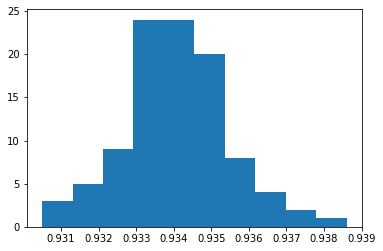

In [14]:
mu, std = norm.fit(best_accuracy)
print(f"mu = {mu:.4f}, std = {std:.4f}")
plt.hist(best_accuracy, bins=10)
plt.show()

For this the average accuracy of a convolutional network has an accuracy of 93.4% with a standard deviation of 1.4e-3.